In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_text as tf_text
import os
from nltk.stem import WordNetLemmatizer
import sklearn
from sklearn.metrics import accuracy_score
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.model_selection import train_test_split
import re
import functools
import nltk
from copy import deepcopy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

DESKTOP = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop')


def kaggle_submission(predictions, outputname=None):
    ids = test_df.id.astype(int).to_numpy()
    if not outputname:
        outputname= "my_predictions"
    results = pd.DataFrame(zip(ids, predictions.round()), columns=["id", "target"])
    results.target = results.target.astype(int)
    output = f"{DESKTOP}/{outputname}.csv"
    results.to_csv(output, index=False)
    return results

In [2]:
PATH = r"D:\Data for python\Kaggle\nlp-getting-started"
files = [os.path.join(PATH, file) for file in os.listdir(PATH) if file.endswith(".csv")]
files

['D:\\Data for python\\Kaggle\\nlp-getting-started\\sample_submission.csv',
 'D:\\Data for python\\Kaggle\\nlp-getting-started\\test.csv',
 'D:\\Data for python\\Kaggle\\nlp-getting-started\\train.csv']

In [3]:
train_df = pd.read_csv(files[2])
test_df = pd.read_csv(files[1])

In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
df = train_df.copy()

In [8]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
text_array = df.text.to_numpy()
test_array = test_df.text.to_numpy()
concat_text = ' '.join(text for text in text_array)

In [ ]:
sample = "Markets ablaze http://t.co/lHYXEOHY6C dsadas"
match = re.search(r"http://t.co/.*($|\s)", sample)
match.group()


KERAS EMBEDDING 

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(text_array)

In [ ]:
num_words = 5000
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'
num_oov_buckets= 500

In [ ]:
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(text_array)

In [ ]:
train_sequences = tokenizer.texts_to_sequences(text_array)
test_sequences = tokenizer.texts_to_sequences(test_array)

In [ ]:
maxlen = max([len(x) for x in train_sequences])
maxlen

In [ ]:
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

In [ ]:
x = train_padded
y = df.target.to_numpy()

In [ ]:
x_train_full , x_test , y_train_full, y_test =  train_test_split(x, y, test_size=0.1)
x_valid, x_train =  x_train_full[6000:], x_train_full[:6000]
y_valid, y_train = y_train_full[6000:],  y_train_full[:6000]

In [ ]:
x_train.shape

In [ ]:
#optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

In [ ]:
embed_size = 128
vocab_size = num_words
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           input_shape=[None], mask_zero=True),
    keras.layers.GRU(3,return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    keras.layers.GRU(3),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])


In [784]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_accuracy"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=1),
]

In [ ]:
history = model.fit(x_train, y_train, epochs=20, validation_data=[x_valid, y_valid], callbacks=callbacks)

In [ ]:
y_pred = model.predict(x_test)
y_true = y_test


In [ ]:
y_pred = np.round(y_pred)

In [ ]:
accuracy_score(y_true, y_pred)

In [ ]:
from matplotlib import pyplot as plt

metric = "accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [ ]:
kaggle_predictions = model.predict(test_padded)

In [ ]:
predictions = kaggle_predictions.round()

In [ ]:
predictions.shape[0]

In [ ]:
kaggle_submission(predictions)

WORD EMBEDDINGS WITH GLOVE AND NLTK CLEANING

In [84]:
EMBED_DIM = 50
glove_path = fr"D:\Data for python\datasets\glove.twitter.27B\glove.twitter.27B.{EMBED_DIM}d.txt"

In [85]:
def dict_from_embeddings(filename):
    embeddings = {}
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            line = line.split(' ')

            try:
                embeddings[line[0]] = np.array(line[1:], dtype=float)
            except:
                continue
    return embeddings


In [86]:
embedding_dict = dict_from_embeddings(glove_path)

In [87]:
len(embedding_dict)

1193515

In [88]:
def message_to_token_list(text):
  tokenizer = nltk.RegexpTokenizer(r'\w+')
  lemmatizer = nltk.WordNetLemmatizer()
  tokens = tokenizer.tokenize(text)
  lowercased_tokens = [token.lower() for token in tokens]
  lemmatized_tokens = [lemmatizer.lemmatize(t) for t in lowercased_tokens]
  useful_tokens = [token for token in lemmatized_tokens if token in embedding_dict]
  return useful_tokens



def vectorize_words(train_data: np.array):
  all_word_vector_sequences = []

  for message in train_data[:,3]:
    message_as_vector_seq = message_to_word_vectors(message)
    if message_as_vector_seq.shape[0] == 0:
      message_as_vector_seq = np.zeros(shape=(1, 50))

    all_word_vector_sequences.append(message_as_vector_seq)
  
  return all_word_vector_sequences  



def message_to_word_vectors(message, word_dict=embedding_dict):
  processed_list_of_tokens = message_to_token_list(message)

  vectors = []
  for token in processed_list_of_tokens:
    if token not in word_dict:
      continue
    
    token_vector = word_dict[token]
    vectors.append(token_vector)
  
  return np.array(vectors, dtype=float)

In [89]:
y = train_df.target.to_numpy()

In [90]:
x_train_full , x_test , y_train_full, y_test =  train_test_split(train_df.to_numpy(), y, test_size=0.1)
x_valid, x_train =  x_train_full[5000:], x_train_full[:5000]
y_valid, y_train = y_train_full[5000:],  y_train_full[:5000]

In [91]:
X_train = vectorize_words(x_train)
x_test = vectorize_words(x_test)
x_valid = vectorize_words(x_valid)


print(len(X_train), len(X_train[0]), len(x_test), len(x_valid))

5000 15 762 1851


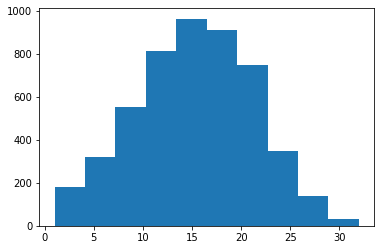

In [92]:
sequence_lengths = []

for i in range(len(X_train)):
  sequence_lengths.append(len(X_train[i]))

import matplotlib.pyplot as plt

plt.hist(sequence_lengths)
plt.show()

In [93]:
pd.Series(sequence_lengths).describe()

count    5000.000000
mean       15.317200
std         5.763022
min         1.000000
25%        11.000000
50%        15.000000
75%        20.000000
max        32.000000
dtype: float64

In [94]:
MAX_SEQ_LEN = pd.Series(sequence_lengths).max() + 2


def pad_X(X, desired_sequence_length=MAX_SEQ_LEN):
  padded_sequences = pad_sequences(X, maxlen=desired_sequence_length, padding='post', truncating='post')
  return padded_sequences

In [95]:
X_train = pad_X(X_train)
x_test = pad_X(x_test)
X_train.shape

(5000, 34, 50)

In [96]:
X_val, y_val = pad_X(x_valid), y_valid
X_val = pad_X(X_val)

X_val.shape

(1851, 34, 50)

In [97]:
## GUY'S MODEL


# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import AUC
# from tensorflow.keras.callbacks import ModelCheckpoint

# callback = ModelCheckpoint('model/', save_best_only=True)

# model = keras.Sequential([])

# model.add(keras.layers.Input(shape=(MAX_SEQ_LEN, 50)))
# model.add(keras.layers.LSTM(64, return_sequences=True))
# model.add(keras.layers.Dropout(0.2))
# model.add(keras.layers.LSTM(64, return_sequences=True))
# model.add(keras.layers.Dropout(0.2))
# model.add(keras.layers.LSTM(64, return_sequences=True))
# model.add(keras.layers.Dropout(0.2))
# model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(1, activation='sigmoid'))

# model.compile(optimizer="Nadam", 
#               loss="binary_crossentropy", 
#               metrics=['accuracy', AUC(name='auc')])

In [98]:
optimizer = keras.optimizers.SGD(learning_rate = 0.001, momentum = 0.9, nesterov=True)

In [150]:
model = keras.Sequential([])

model.add(keras.layers.Input(shape=(MAX_SEQ_LEN, EMBED_DIM)))
# model.add(keras.layers.GRU(3,return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
# model.add(keras.layers.GRU(3))
# model.add(keras.layers.Conv1D(filters=64, kernel_size=5,
#           strides=2, padding="same"))
# model.add(keras.layers.BatchNormalization())
# model.add(keras.layers.Conv1D(filters=64, kernel_size=5,
#               padding="same"))
# model.add(keras.layers.BatchNormalization())


model.add(keras.layers.Bidirectional(keras.layers.GRU(16, return_sequences=True)))
model.add(keras.layers.GRU(16, dropout=0.2,
          recurrent_dropout=0.2, return_sequences=True))
model.add(keras.layers.GRU(16, return_sequences=False))
# model.add(keras.layers.GRU(128, dropout=0.2,
#           recurrent_dropout=0.2, return_sequences=True))
# model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])


In [151]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 34, 32)           6528      
 nal)                                                            
                                                                 
 gru_40 (GRU)                (None, 34, 16)            2400      
                                                                 
 gru_41 (GRU)                (None, 16)                1632      
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 10,577
Trainable params: 10,577
Non-trainable params: 0
_________________________________________________________________


In [152]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_accuracy"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=1),
]

In [153]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, callbacks=[callbacks]) 

Epoch 1/30
157/157 [==============================] - 22s 79ms/step - loss: 0.6765 - accuracy: 0.5816 - val_loss: 0.6605 - val_accuracy: 0.6180 - lr: 0.0010
Epoch 2/30
157/157 [==============================] - 11s 71ms/step - loss: 0.5304 - accuracy: 0.7484 - val_loss: 0.4940 - val_accuracy: 0.7785 - lr: 0.0010
Epoch 3/30
157/157 [==============================] - 11s 69ms/step - loss: 0.4929 - accuracy: 0.7782 - val_loss: 0.4792 - val_accuracy: 0.7920 - lr: 0.0010
Epoch 4/30
157/157 [==============================] - 11s 69ms/step - loss: 0.4794 - accuracy: 0.7836 - val_loss: 0.4700 - val_accuracy: 0.7925 - lr: 0.0010
Epoch 5/30
157/157 [==============================] - 11s 70ms/step - loss: 0.4721 - accuracy: 0.7916 - val_loss: 0.4624 - val_accuracy: 0.7952 - lr: 0.0010
Epoch 6/30
157/157 [==============================] - 11s 69ms/step - loss: 0.4663 - accuracy: 0.7926 - val_loss: 0.4624 - val_accuracy: 0.7979 - lr: 0.0010
Epoch 7/30
157/157 [==============================] - 11s 

SCORE   

In [154]:
y_pred = model.predict(x_test)
y_true = y_test

accuracy_score(y_true, y_pred.round())


24/24 [==============================] - 3s 26ms/step


0.8162729658792651


Best validation acc so far = 0.8241469816272966

In [155]:
test_data = test_df.to_numpy()
test_data = vectorize_words(test_data)
test_data = pad_X(test_data)

classifications = model.predict(test_data)

submission = kaggle_submission(classifications, "my_submission '-'")

102/102 [==============================] - 2s 17ms/step
